## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [4]:
df = data.read.df_okx_20240116_0131
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [5]:
df.tail(3)

,timestamp,symbol,open,high,low,close,volume
4060708,2024-01-31 04:58:00,NEO-USDT-SWAP,11.6310,11.6320,11.6240,11.6260,310.0000
4060709,2024-01-31 04:58:00,BTC-USD-SWAP,42960.8000,42960.9000,42951.9000,42954.7000,3.8149
4060710,2024-01-31 04:58:00,CFX-USDT-SWAP,0.2263,0.2263,0.2259,0.2261,140070.0000


In [6]:
len([s for s in all_symbols if 'USDT' in s])

163

## multiple symbols

In [7]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [8]:
jitter_recovery_feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40)
jitter_recovery_feature_param_ = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(8)

In [9]:
dfst_feature = df.set_index(['symbol', 'timestamp'])
for i, symbol in enumerate(all_symbols):
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    dfs_ = dfs.resample('5min').last()
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs_, jitter_recovery_feature_param_)

    print(f'{i} symbol: {symbol}: {len(df_feature[df_feature.ch_max >= 0.15])}')
    if len(df_feature[df_feature.ch_max >= 0.15]) == 0: continue
    
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_feature_param)
    
    for column in df_feature.columns:
        dfst_feature.loc[symbol, column] = df_feature[column].values

0 symbol: OP-USDT-SWAP: 0
1 symbol: JST-USDT-SWAP: 0
2 symbol: LUNC-USDT-SWAP: 0
3 symbol: LOOKS-USDT-SWAP: 4
4 symbol: XRP-USDT-SWAP: 0
5 symbol: SLP-USDT-SWAP: 0
8 symbol: ANT-USDT-SWAP: 0
9 symbol: MANA-USDT-SWAP: 0
11 symbol: LTC-USDT-SWAP: 0
12 symbol: CORE-USDT-SWAP: 0
13 symbol: KLAY-USDT-SWAP: 4
14 symbol: WAVES-USDT-SWAP: 0
15 symbol: NFT-USDT-SWAP: 0
17 symbol: LRC-USDT-SWAP: 0
18 symbol: SAND-USDT-SWAP: 0
19 symbol: FLM-USDT-SWAP: 0
20 symbol: FLOW-USDT-SWAP: 0
22 symbol: BAT-USDT-SWAP: 0
23 symbol: SUSHI-USDT-SWAP: 0
24 symbol: GMX-USDT-SWAP: 0
25 symbol: PEPE-USDT-SWAP: 0
26 symbol: LQTY-USDT-SWAP: 0
27 symbol: BNB-USDT-SWAP: 0
28 symbol: API3-USDT-SWAP: 9
30 symbol: AGIX-USDT-SWAP: 0
31 symbol: ONT-USDT-SWAP: 0
32 symbol: BADGER-USDT-SWAP: 0
33 symbol: STX-USDT-SWAP: 0
34 symbol: CRO-USDT-SWAP: 0
35 symbol: PERP-USDT-SWAP: 0
36 symbol: GALA-USDT-SWAP: 0
38 symbol: RON-USDT-SWAP: 0
40 symbol: TIA-USDT-SWAP: 0
41 symbol: ETC-USDT-SWAP: 0
42 symbol: WAXP-USDT-SWAP: 0
43 symb

In [10]:
symbol_with_jumps = [s for s in list(set(list(dfst_feature[dfst_feature.ch_max >= 0.18].index.get_level_values(0)))) if 'USDT' in s]
len(symbol_with_jumps)

8

In [11]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    jitter_recovery_feature_param, 
    0.20, -0.04, 0.02, is_long_term=False)

In [12]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [13]:
dfst_trading = df.set_index(['symbol', 'timestamp'])
for i, symbol in enumerate(symbol_with_jumps):
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    print(f'{i} symbol: {symbol}')
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)
    df_trading = algo.jitter_recovery.calculate.add_trading_columns(df_feature, jitter_recovery_trading_param)
    for column in df_trading.columns:
        dfst_trading.loc[symbol, column] = df_trading[column].values

0 symbol: YFII-USDT-SWAP
1 symbol: CEL-USDT-SWAP
2 symbol: SWEAT-USDT-SWAP
3 symbol: API3-USDT-SWAP
4 symbol: UMA-USDT-SWAP
5 symbol: NMR-USDT-SWAP
6 symbol: KLAY-USDT-SWAP
7 symbol: CFX-USDT-SWAP


<Axes: xlabel='timestamp'>

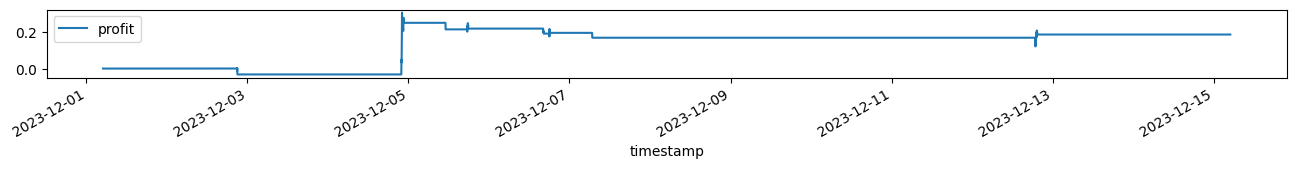

In [15]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

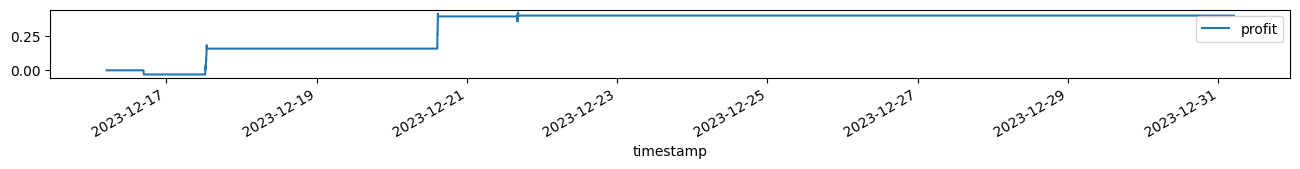

In [28]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

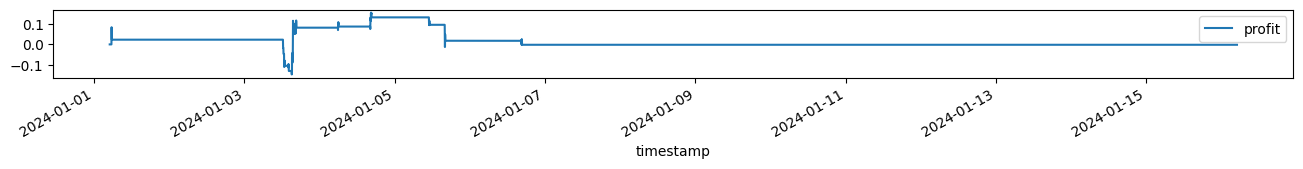

In [42]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

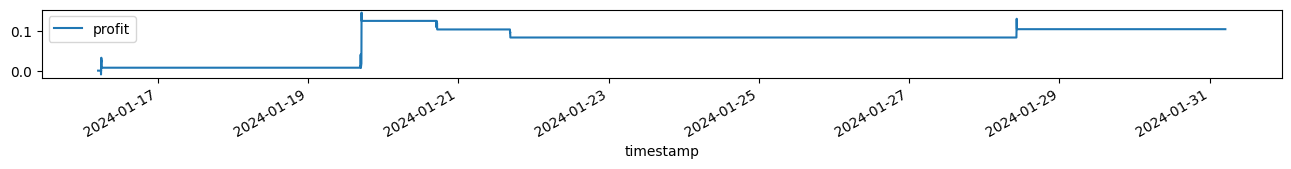

In [175]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

In [43]:
dfst_trading[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
STARL-USDT-SWAP,-0.039526
TURBO-USDT-SWAP,-0.032593
ARB-USDT-SWAP,-0.029031
ENS-USDT-SWAP,-0.025108
YFII-USDT-SWAP,-0.019427
...,...
SLP-USDT-SWAP,0.000717
TRB-USDT-SWAP,0.022805
GFT-USDT-SWAP,0.028540


In [354]:
dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

open                    0.007071
high                    0.007091
low                     0.007068
close                   0.007091
volume             665660.000000
value                   0.007091
ch_max                  0.008821
ch_min                 -0.003391
ch_since_max            0.000000
ch_since_min            0.005388
distance_max_ch         0.000000
distance_min_ch         9.000000
Name: 2023-12-07 16:38:00, dtype: float64

In [355]:
'''
{
'value': 0.008794, 
'ch_largest': 0.2634039043167446, 'ch_smallest': 0.0, 
'ch_since_largest': -0.043090315560391786, 'ch_since_smallest': 0.20896343139950505, 
'distance_largest_ch': 31, 'distance_smallest_ch': 59
}
'''

"\n{\n'value': 0.008794, \n'ch_largest': 0.2634039043167446, 'ch_smallest': 0.0, \n'ch_since_largest': -0.043090315560391786, 'ch_since_smallest': 0.20896343139950505, \n'distance_largest_ch': 31, 'distance_smallest_ch': 59\n}\n"

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

In [44]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-01 05:33:00, TRB-USDT-SWAP, 221.77, position_changed: 1.0
2024-01-01 05:37:00, TRB-USDT-SWAP, 209.21, position_changed: -1.0
2024-01-01 05:38:00, TRB-USDT-SWAP, 207.11, position_changed: 1.0
2024-01-01 05:40:00, TRB-USDT-SWAP, 214.11, position_changed: -1.0
2024-01-03 12:19:00, STARL-USDT-SWAP, 2.53e-06, position_changed: 1.0
2024-01-03 12:20:00, STARL-USDT-SWAP, 2.63e-06, position_changed: -1.0
2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0
2024-01-03 12:40:00, PEOPLE-USDT-SWAP, 0.01551, position_changed: 1.0
2024-01-03 12:41:00, PEOPLE-USDT-SWAP, 0.01649, position_changed: -1.0
2024-01-03 12:46:00, PEOPLE-USDT-SWAP, 0.01661, position_changed: 1.0
2024-01-03 12:52:00, PEOPLE-USDT-SWAP, 0.01651, position_changed: -1.0
2024-01-03 14:02:00, ENS-USDT-SWAP, 12.462, position_changed: 1.0
2024-01-03 14:10:00, ENS-USDT-SWAP, 12.773, position_changed: -1.0
2024-01-03 15:05:00, CORE-USDT-SWAP, 0.6703, po

## single symobl

In [148]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [149]:
symbol_investigate = 'ARB-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [150]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40), 
    0.20, -0.04, 0.02, is_long_term=False)

In [151]:
df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)
df_trading = algo.jitter_recovery.calculate.add_trading_columns(df_feature, jitter_recovery_trading_param)

In [156]:
df_feature[(df_feature.ch_max >= 0.20) & (df_feature.ch_since_max <= -0.02)].head()

,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,v_ch_max_is_to,v_ch_min_is_to,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-03 12:27:00,1.7395,0.248013,-0.218257,1.4721,1.8831,1.8372,1.4721,-0.053179,0.181645,3,18,1,1.7395,1.0,1.7395,0,0.000000,0.000000,0.0000,0.000000
2024-01-03 12:28:00,1.7900,0.248013,-0.218257,1.4721,1.8831,1.8372,1.4721,-0.025691,0.215950,4,19,1,1.7395,0.0,1.7395,1,0.029031,0.029031,-0.0505,-0.029031
2024-01-03 12:32:00,1.8000,0.248013,-0.216635,0.0000,0.0000,0.0000,0.0000,-0.020248,0.222743,8,23,0,0.0000,0.0,0.0000,0,0.000000,0.000000,0.0000,0.000000
2024-01-03 12:40:00,1.8606,0.302833,-0.188165,0.0000,0.0000,0.0000,0.0000,-0.029876,0.263909,3,31,0,0.0000,0.0,0.0000,0,0.000000,0.000000,0.0000,0.000000
2024-01-03 12:41:00,1.8612,0.302833,-0.188165,0.0000,0.0000,0.0000,0.0000,-0.029564,0.264316,4,32,0,0.0000,0.0,0.0000,0,0.000000,0.000000,-0.0000,-0.000000


<Axes: xlabel='timestamp'>

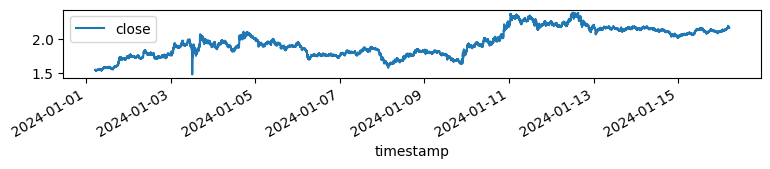

In [157]:
dfs[['close']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

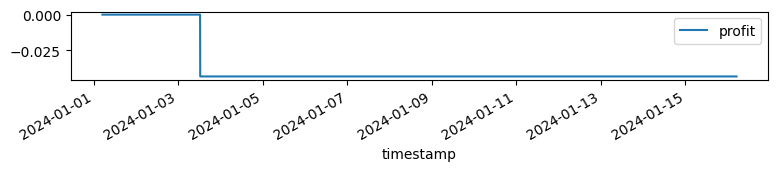

In [158]:
df_trading[['profit']].cumsum().plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

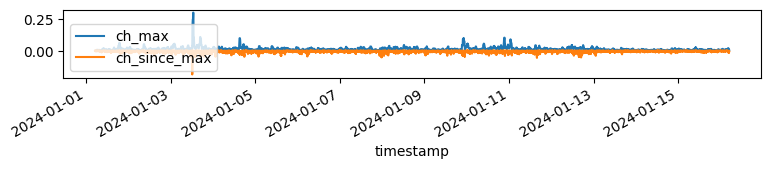

In [155]:
df_trading[['ch_max', 'ch_since_max']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

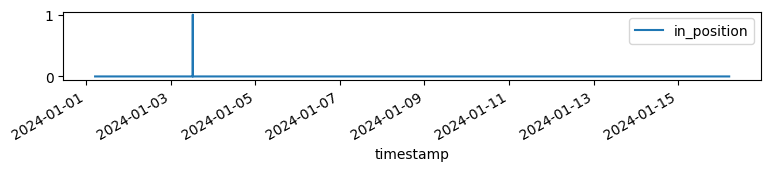

In [142]:
df_trading[['in_position']].plot(figsize=(9,1))

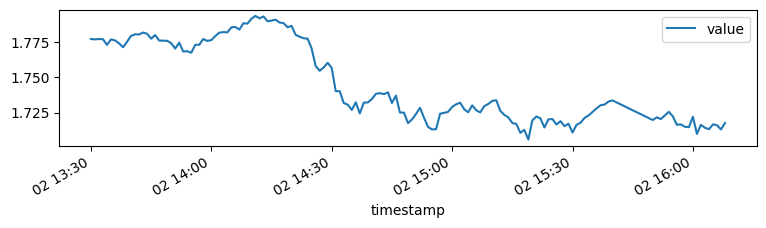

In [143]:
df_plot = df_trading.iloc[1950:2100]
ax = df_plot[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_plot[df_plot.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_plot[df_plot.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

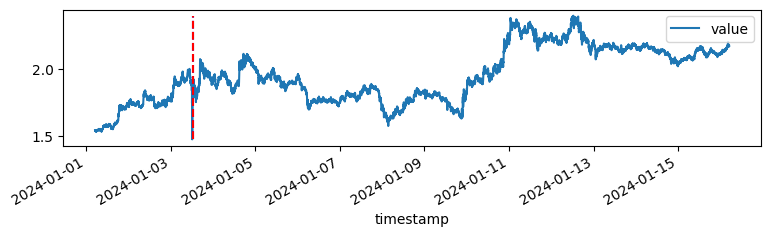

In [144]:
ax = df_trading[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_trading[df_trading.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_trading[df_trading.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

In [145]:
df_trading[
    (df_trading.index >=  '2024-01-03 12:14:00') &
    (df_trading.index <=  '2024-01-03 12:18:00')
]

,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,v_ch_max_is_to,v_ch_min_is_to,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-03 12:14:00,1.6811,0.141974,-0.232522,0.0,0.0,0.0,0.0,0.000000,0.141974,0,5,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 12:15:00,1.7300,0.175192,-0.232522,0.0,0.0,0.0,0.0,0.000000,0.175192,0,6,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 12:16:00,1.7613,0.196454,-0.231440,0.0,0.0,0.0,0.0,0.000000,0.196454,0,7,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 12:17:00,1.7545,0.196454,-0.229590,0.0,0.0,0.0,0.0,-0.003861,0.191835,1,8,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2024-01-03 12:18:00,1.7891,0.215339,-0.227771,0.0,0.0,0.0,0.0,0.000000,0.215339,0,9,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0


In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:27:00,1.7395,1,1.0,0.000,0.000000
2024-01-03 12:29:00,1.8060,0,-1.0,-0.016,-0.008939


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0


<Axes: xlabel='timestamp'>

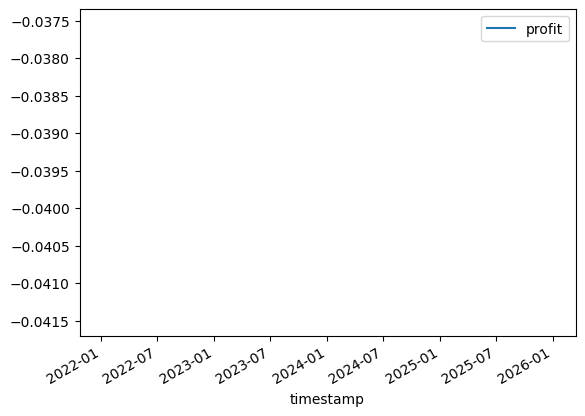

In [114]:
df_trading[(df_trading.in_position.shift() != 0)][['profit']].cumsum().plot()